## [Lab 7] Backpropagation Algorithm
### 0. Introduction
> Last week, we were discussing the feed forward algorithm and how it works on the already trained weights. For this week, we will discuss and work on the backpropagation algorithm.

> Backpropagation is a fundamental algorithm used in training artificial neural networks. It involves propagating error information backward through the network, updating the weights of each neuron to minimize the difference between the actual and predicted outputs. Initial work includes performing the forward propagation and calculating the output for each of the layers (the error between the actual and predicted value), until we reach the output layer. After that, we are going backwards and performing the backpropagation.
It means adjusting the model's parameters to minimize the error (updating the corresponding weights), using gradient descent.  

> Through backpropagation, neural networks can adjust their parameters to improve performance on tasks such as classification, regression, and pattern recognition.



---
**The goal** of this lab is to improve the performance of last week's model by applying the backpropagation algorithm.

---
A figure below shows the basic backpropagation setup.

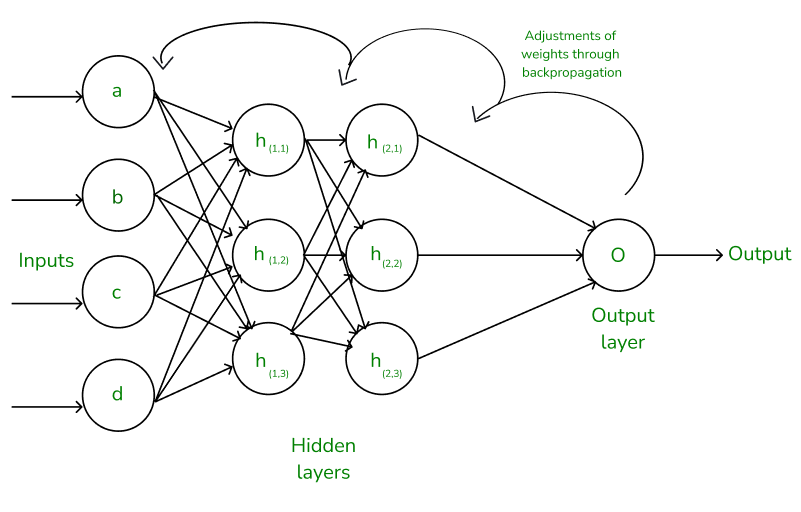

A bit of a note: We are working on the same datasets for the input features and labels as we were previously. You can find them in the following [LMS folder](https://learning.ibu.edu.ba/mod/folder/view.php?id=82603). To remind yourself on how the structure of our neural network looked like, you can visit the following last week's [notebook](https://colab.research.google.com/drive/1WKs_xx3yD4FEg5HXpRfNEpRQe8Sl_91c).





In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
def is_number(s):
    if s is None: return False
    try:
        complex(s)
    except ValueError:
        return False

    return True

def read_file(file_path, offset=1):
    try:
        with open(file_path, 'r') as file:
            data = []
            lines = file.readlines()

            keys = lines[0].split(',')
            for i in range(offset, len(lines)):
                data_row = [
                    float(cell.strip('\n')) if is_number(cell.strip('\n')) else cell.strip('\n')
                    for cell in lines[i].split(',')
                ]
                data.append(data_row)
            return data
    except FileNotFoundError:
        raise RuntimeError("File not found.")
    except Exception as e:
        raise RuntimeError(f"An error occurred: {e}")

In [130]:
def size(A):
  if A is None:
    raise ValueError('Matrix is None')

    rows = len(A)
    if rows > 0:
        if type(A[0]) != list:
            raise RuntimeError('matrix should be list of lists')

    return rows, len(A[0]) if rows > 0 else 0, 0


def generate(rows, columns, default_value=0):
  A = []
  for i in range(rows):
    A.append([default_value for i in range(columns)])
  return A

def trans(A):
  rows, cols = size(A)
  At = generate(cols, rows)
  for i in range(cols):
    for j in range(rows):
      At[i][j] = A[j][i]

  return At

def concat(A, B):
  (row_A, col_A) = size(A)
  (row_B, col_B) = size(B)
  C = []
  for i in range(0, row_A):
    data_row = []
    for j in range(0,col_A):
      data_row.append(A[i][j])
    for j in range(0,col_B):
      data_row.append(B[i][j])
    C.append(data_row)
  return C

def mul(A, B):
  rows_a, cols_a = size(A)
  rows_b, cols_b = size(B)
  if cols_a != rows_b:
    raise RuntimeError('matrix dimm does not match')
  R = generate(rows_a, cols_b)
  for i in range(rows_a):
    for j in range(cols_b):
        R[i][j] = sum(A[i][k] * B[k][j] for k in range(cols_a))

  return R

def dot_product(X, Y):
    return sum(x * y for x, y in zip(X, Y))

def reshape(X, row_length=20):
  reshaped_X = []
  for record in X:
    reshaped_record = [record[i:i+row_length] for i in range(0, len(record), row_length)]
    reshaped_X.append(reshaped_record)
  return reshaped_X

def subtract(matrix1, matrix2):
    if len(matrix1) != len(matrix2) or len(matrix1[0]) != len(matrix2[0]):
        raise ValueError("Matrices must have the same dimensions for subtraction")

    result = []
    for i in range(len(matrix1)):
        row = []
        for j in range(len(matrix1[i])):
            row.append(matrix1[i][j] - matrix2[i][j])
        result.append(row)

    return result

def print_dimensions(matrix):
    rows = len(matrix)
    columns = len(matrix[0]) if rows > 0 else 0
    print("Rows:", rows)
    print("Columns:", columns)

def scalar_multiply(matrix, scalar):
    rows, cols = size(matrix)
    result = generate(rows, cols)

    for i in range(rows):
        for j in range(cols):
            result[i][j] = matrix[i][j] * scalar

    return result

def add(matrix1, matrix2):
    rows1, cols1 = size(matrix1)
    rows2, cols2 = size(matrix2)

    if rows1 != rows2 or cols1 != cols2:
        raise ValueError("Matrices must have the same dimensions for addition.")

    result = generate(rows1, cols1)

    for i in range(rows1):
        for j in range(cols1):
            result[i][j] = matrix1[i][j] + matrix2[i][j]

    return result

**Important**: To avoid having lots of code and since you will be needing lots of matrix methods, on this [link](https://colab.research.google.com/drive/1AyPkxjl5EndOdhlqpY_S_EyhcOTitDFd#scrollTo=EOH9rfbPUE73), you can find a helper notebook with most of the necessary matrix methods that will be needed to code the backpropagation algorithm, alongside with reading from file function and reshape function.

In [95]:
x = read_file('./sample_data/x.csv')
y = read_file('./sample_data/y.csv')

In [96]:
print(x[:100])

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003228567934450315, -0.0009155762096938421, -0.02535322652969737, -0.03859311282571683, -0.03840446781623286, -0.01937466878643365, 0.0003909339203456832, 8.193714076066534e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0001174024703436519, -0.0008247549019608215, -0.00705284926470604, -0.01096621391612255, 0.1968833401416119, 0.3209088670118077, 0.3189123944716769, 0.1417196520969492, -0.01568201933551217, -0.0002650633169934203, 3.30194447841521e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0002450980392156869, -0.00196159960865843, -0.01207158905228751, 0.005623723447712434, 0.2903474775326795, 0.8644130412581698, 0.9883908455967276, 0.9855265352668842, 0.7994684436274506, 0.1567231753812639, -0.0174198325163396, 0.00053931759

In [97]:
print(y)

[[10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0], [10.0],

### 1. Weights Initialization

> As we mentioned above, by using the gradient descent, we will update the weights in every iteration and adjust them to predict the digit correctly. Meaning, we cannot use the trained weights from last week anymore, but we need to generate and populate them with random values, that will be updated later on. You need to create W1 (dimensions: 401 x 25) and W2 (26 x 10). You can use generate function that we coded before.

> **A bit of a note**:  Use the random module and uniform method, to generate decimal numbers between 0 and 1.

In [99]:
import random

In [98]:
import random

def generate_weights(rows, columns):
    W = []
    for _ in range(rows):
        row = [random.uniform(0, 1) for _ in range(columns)]
        W.append(row)
    return W

In [100]:
W1 = generate_weights(401, 25)
W2 = generate_weights(26, 10)

### 2. Forward Propagation

> In the forward propagation, output of every layer is the input for the next one, which we usually multiply with the weights. You can follow the below picture from the lecture, to feed forward the neural network. Just be advised that this neural network contain 3 hidden layers, whereas the network we are trying to create contains 2. Just be advised to pay close attention to the picture below and adjust the parameters accordingly to fit our network. This function takes W1, W2 and one record from the X input features dataset as the parameters. You should calculate the input for the activation function for each of the layers (z) and the outputs of each of the neurons in the corresponding layer (a).

This function should return the following:


```
a3, z3, a2, z2, a1
```


**A bit of a note**: Add the bias term to the X record firstly. The activation function is the sigmoid, which is given to you as the helper method below.





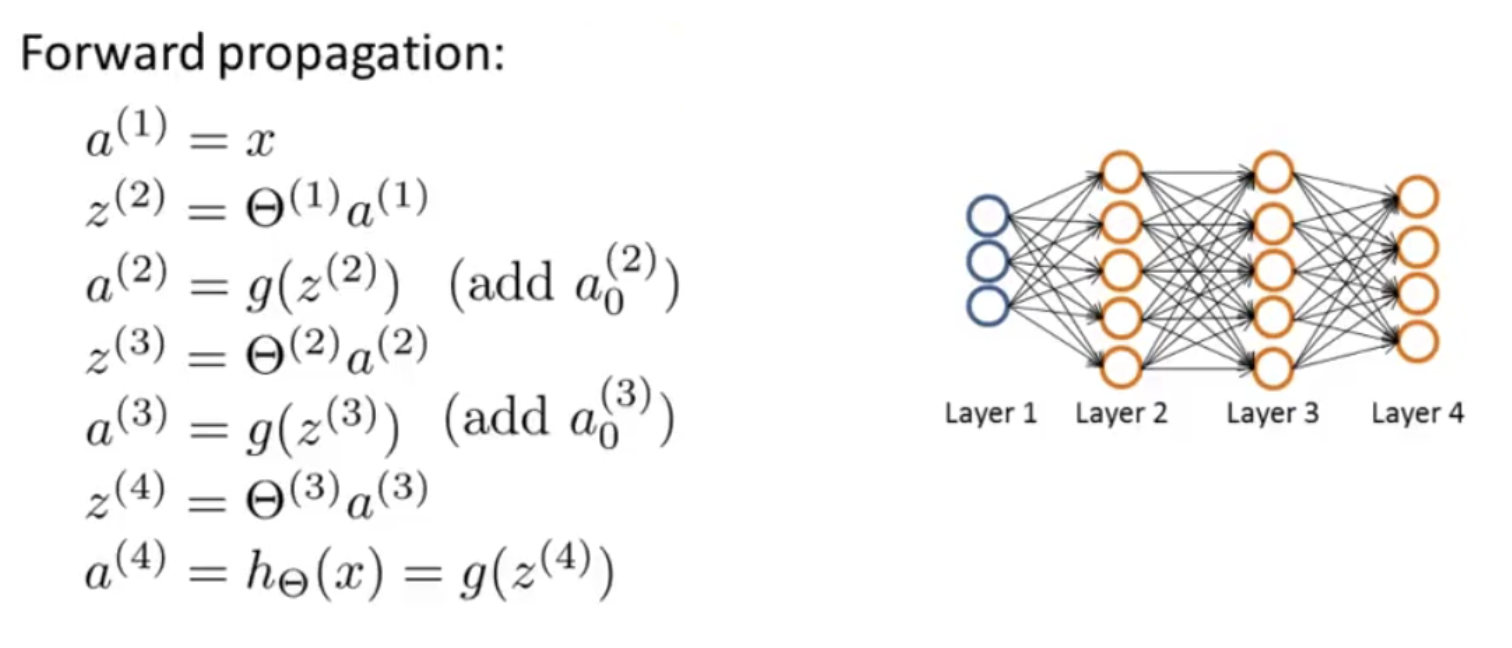

In [102]:
def sigmoid(z):
  if type(z) is list:
    for i in range(len(z)):
      if type(z[i]) is list:
        for j in range(len(z[0])):
          z[i][j] = 1/(1 + 2.71828**(float(-z[i][j])))
      else:
        z[i] = 1/(1 + 2.71828**(float(-z[i])))
  else:
    z = 1/(1 + 2.71828**(float(-z)))

  return z

In [101]:
def forward_propagation(W1, W2, x):
  pass

In [103]:
def forward_propagation(W1, W2, x):
    a1 = [[1] + x]

    z2 = mul(a1, W1)

    a2 = sigmoid(z2)

    a2 = [[1] + a2[0]]

    z3 = mul(a2, W2)
    a3 = sigmoid(z3)

    return a3, z3, a2, z2, a1

In [104]:
a3, z3, a2, z2, a1 = forward_propagation(W1, W2, x[0])

### 3. Backpropagation Algorithm
> To perform the backpropagation on our neural network, we go from the output layer and calculate the delta error for each one of the layers in the network.
You can follow the picture below and use these equations to calculate the delta for each layer. Just, once again, you should pay close attention to the fact that these equations are made based to the neural network that contains 3 hidden layers. Meaning, you will have one less delta. This function is taking W1, W2, one record of the X dataset and the one corresponding record from the Y label dataset. It should call the forward propagation method to receive the values of a3, z3, a2, z2 and a1.

**A bit of a note**: You are given the sigmoid gradient and elementwise multiplication of the matrices as the helper methods. **g'(z)** below is sending the z as the parameter to the sigmoid gradient method. Additionally, for delta3 shown below, sigmoid gradient is being element-wisely multiplied with the product of delta4 and the transpose of W3. That's why we need the elementwise multiplication method.


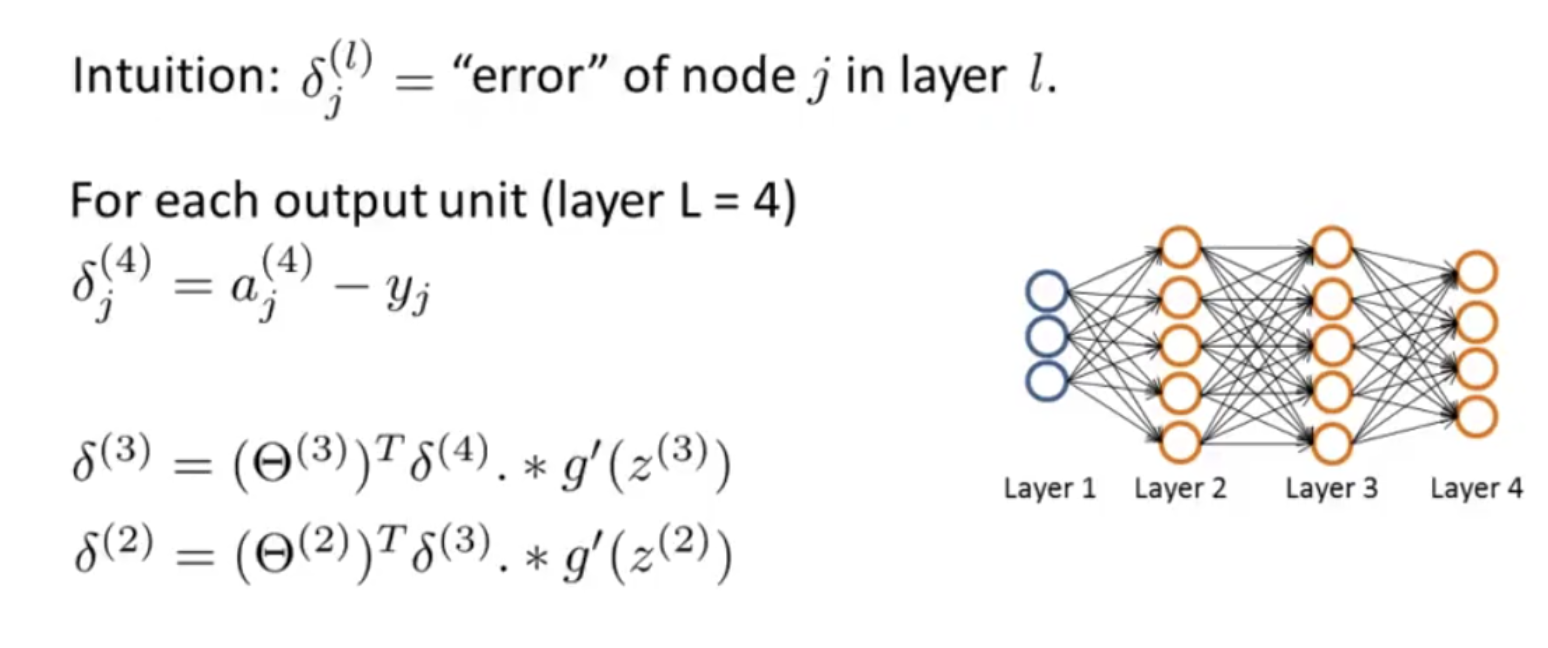

In [106]:
def elementwise_multiply(matrix1, matrix2):

    if len(matrix1) != len(matrix2) or len(matrix1[0]) != len(matrix2[0]):
        raise ValueError("Matrices must have the same dimensions for element-wise multiplication")

    result = [[0] * len(matrix1[0]) for _ in range(len(matrix1))]

    for i in range(len(matrix1)):
        for j in range(len(matrix1[0])):
            result[i][j] = matrix1[i][j] * matrix2[i][j]


In [105]:
def sigmoid_gradient(z):
    if type(z) is list:
        for i in range(len(z)):
            if type(z[i]) is list:
                for j in range(len(z[0])):
                    sigmoid_z = 1 / (1 + 2.71828**(-float(z[i][j])))
                    z[i][j] = sigmoid_z * (1 - sigmoid_z)
            else:
                sigmoid_z = 1 / (1 + 2.71828**(-float(z[i])))
                z[i] = sigmoid_z * (1 - sigmoid_z)
    else:
        z = 1 / (1 + 2.71828**(-float(z)))
        z = z * (1 - z)

    return z

In [108]:
y_matrix = [[y[0][0] for _ in range(len(a3[0]))]]
y_matrix

[[10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]]

In [107]:
print("a3:", size(a3))
print("z3:", size(z3))
print("a2:", size(a2))
print("z2:", size(z2))
print("a1:", size(a1))
print("W1:", size(W1))
print("W2:", size(W2))

a3: (1, 10)
z3: (1, 10)
a2: (1, 26)
z2: (1, 25)
a1: (1, 401)
W1: (401, 25)
W2: (26, 10)


In [109]:
def back_propagation(W1, W2, x, y):
  pass

In [132]:
def back_propagation(W1, W2, x, y):
    a3, z3, a2, z2, a1 = forward_propagation(W1, W2, x)

    W2 = [row[1:] for row in trans(W2)]
    delta3 = elementwise_multiply(subtract(a3, [y]), sigmoid_gradient(z3))

    delta2 = elementwise_multiply(mul(delta3, W2), sigmoid_gradient(z2))

    delta1 = elementwise_multiply(mul(delta2, trans(W1)), sigmoid_gradient(a1))

    grad_W2 = mul(trans(a2), delta3)
    grad_W1 = mul(trans(a1), delta2)

    return grad_W1, grad_W2, delta2, delta3

In [133]:
grad_W1, grad_W2, _, _ = back_propagation(W1, W2, x[0], y_matrix[0])

TypeError: cannot unpack non-iterable NoneType object

### 4. ANN Gradient

> Now, we need to compute the gradients for each of the layers. Since our neural network contains 2 layers, we will have D1 and D2, that will represent the gradients of the cost functions in the specific layers.

> You can follow the figure below for the calculation of these two values, but here are a few tips. Firstly, generate the D1 and D2 with the same dimensions as W1 and W2 and fill them with 0's. Now, create a for loop that will iterate through each column in the X record that is provided as the parameter. For the D1, you need to sum it with the product of a1 and delta3. Just a short note: You will need to remove one column from the product aforementioned as we added the bias term to the z2 in the backpropagation. We do this to obtain the same dimensions for the product and D1, so we can add them up. Furthermore, for the D2, we sum D2 with the product of transposed a2 and delta3. All that is left to do is to multiply it with the 1/m, where m is the length of the X record that we have as the method parameter. Additionally, for the last part, you can use the scalar multiplication method that we coded a few weeks before.

**Additional note**: You will need to call the backpropagation method in the ANN gradient function, to get the values of a1, a2, delta2 and delta3.

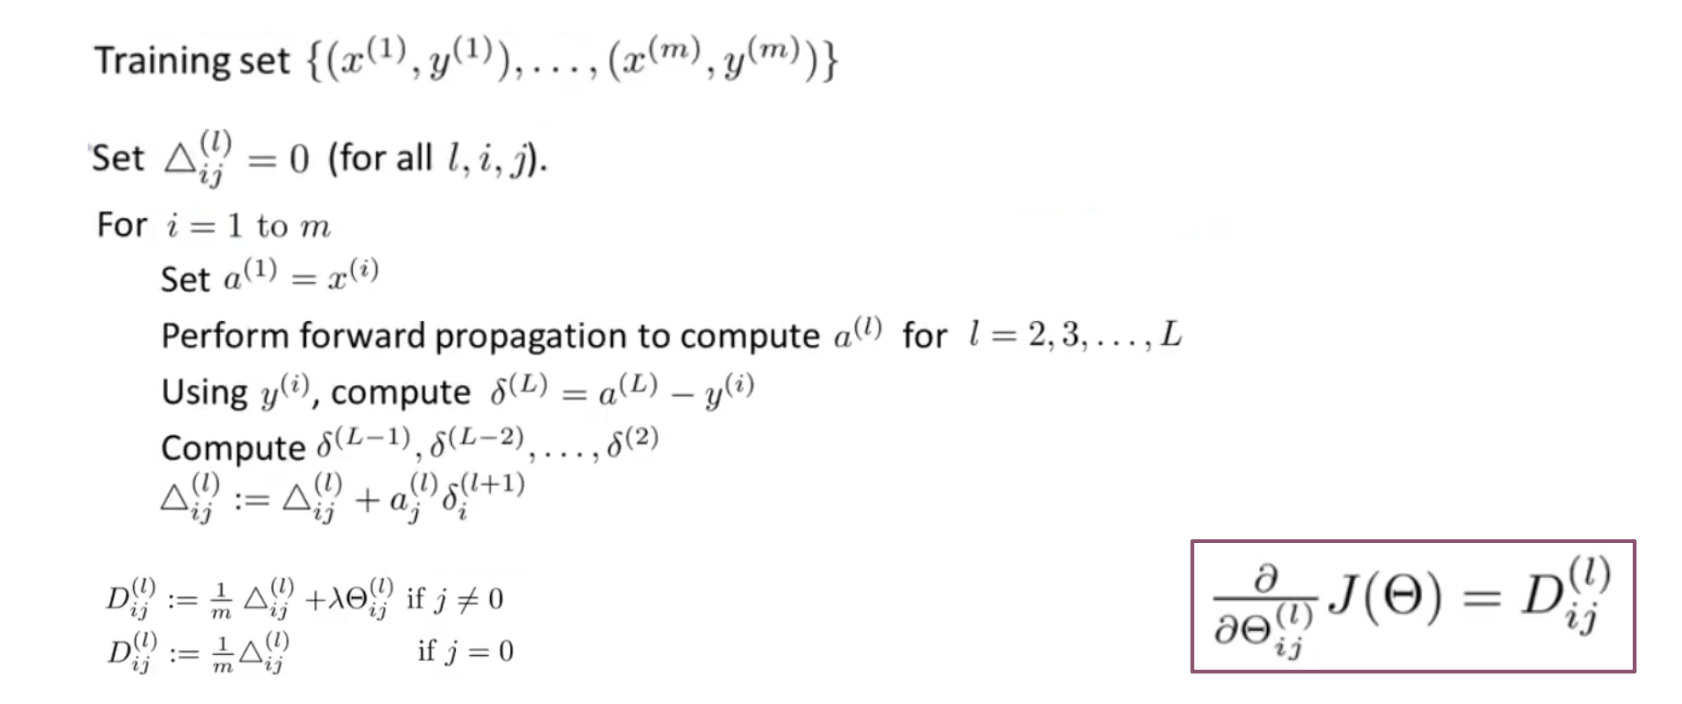

In [74]:
def ann_gradient(W1, W2, X_param, Y_param):
  pass


In [119]:
def ann_gradient(W1, W2, X_param, Y_param):
    D1 = generate(*size(W1))
    D2 = generate(*size(W2))

    m = len(X_param)

    for x, y in zip(X_param, Y_param):
        a3, z3, a2, z2, a1 = forward_propagation(W1, W2, x)

        grad_W1, grad_W2, delta2, delta3 = back_propagation(W1, W2, x, y) # Already removed bias term

        D1 = add(D1, mul(trans([[1] + x]), delta2))
        D2 = add(D2, mul(trans(a2), delta3))

    D1 = scalar_multiply(D1, 1/m)
    D2 = scalar_multiply(D2, 1/m)

    return D1, D2

In [134]:
(D1, D2) = ann_gradient(W1, W2, [x[0]], [y_matrix[0]])

TypeError: __main__.generate() argument after * must be an iterable, not NoneType

In [121]:
print(size(D1))
print(size(D2))
print(size(W1))
print(size(W2))

NameError: name 'D1' is not defined

### 5. Training the Model

> Now, comes the easiest part. You can reuse the logic from training the linear regression model and just update the variables to work for our neural network. The function below should return updated W1 and W2.

Additionally, as you can see below, we have the *expand_Y*  helper method. After you implement the model training function, before calling it, we need to firstly implement encoding of the Y label dataset records. To simplify it, currently, one record of the Y looks like this: $ [8.0] $. Now, we want to reshape it in the following format: $ [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]$. Before calling the train_ann function, firstly implement this and then provide one record from it as the function parameter.


In [22]:
def train_linear_reg(x,
                     y,
                     w0 = 0,
                     w1 = 0,
                     learning_rate = 0.0000004,
                     num_iterations = 1000,
                     logging = False):

    for i in range(num_iterations):
        gradient_w0, gradient_w1 = linear_reg_delta_cost(w0, w1, x, y)
        w0 -= learning_rate * gradient_w0
        w1 -= learning_rate * gradient_w1
        if logging:
          print(str(i) + '. W = (' + str(w0) + ', '+ str(w1) +')')

    return w0, w1 #Function in lab

In [82]:
def linear_reg_delta_cost(w, x, y):
  m = len(y)

  x_matrix = [[1, x_val] for x_val in x]

  y_pred = mul(x_matrix, [[w[0]], [w[1]]])

  diff = subtract(y_pred, [[y_val] for y_val in y])

  x_transpose = trans(x_matrix)

  weighted_sum = mul(x_transpose, diff)

  gradient = [[val[0] / m] for val in weighted_sum]

  return gradient #My function

In [24]:
def train_ann(X_param,
              Y_param,
              W1 = 0,
              W2 = 0,
              learning_rate = 0.0000004,
              num_iterations = 1000,
              logging = False):
  pass #Function in Lab

In [83]:
def train_ann(X_param,
              Y_param,
              W1=0,
              W2=0,
              learning_rate=0.0000004,
              num_iterations=1000,
              logging=False):

    for i in range(num_iterations):
        D1, D2 = ann_gradient(W1, W2, X_param, Y_param)
        W1 = subtract(W1, scalar_multiply(D1, learning_rate))
        W2 = subtract(W2, scalar_multiply(D2, learning_rate))

        if logging:
            print(f"Iteration {i+1}: W1 = {W1}, W2 = {W2}")

    return W1, W2 #My function

In [92]:
def expand_Y(Y):
  rows, _ = size(Y)
  y_new = trans(Y)
  cols = len(set(y_new[0]))
  Y_new = generate(rows, cols)
  for i in range(0, rows):
    Y_new[i][int(Y[i][0]) - 1] = 1
  return Y_new

In [122]:
Y_expanded = expand_Y(y)

W1, W2 = train_ann([x[0]], [Y_expanded[0]], W1, W2, logging=True, learning_rate=0.0005, num_iterations=10)

TypeError: object of type 'NoneType' has no len()

### 6. Model Testing

Now, all that is left to do, is to call the train_ann function and to adjust the learning rate and number of iterations accordingly. You can check the validity of the results you obtained by plotting the digit on a specific index and then calling the ann_function with a record on that index. Since the ann_function returns updated W1 and W2, to check if our model works fine, you can find the index of the maximum element in the a3, or the last output we obtained. The following line of code should do the trick.


```
digit = (a3[0].index(max(a3[0])) + 1) % 10
```



The number should be the same as the one that is plotted.

In [86]:
# W1, W2 = train_ann(X, Y_new, W1, W2, logging=True, learning_rate=0. 0002, num_iterations=1000)

In [87]:
import matplotlib.pyplot as plt
def plot_digit(x):
  newX = trans(reshape(x))
  plt.imshow(newX, cmap="gray")
  plt.show()

In [88]:
W1 = generate_weights(401, 25)
W2 = generate_weights(26, 10)

Please enter the index of the certain digit to test: 2


TypeError: Invalid shape (20, 1, 20) for image data

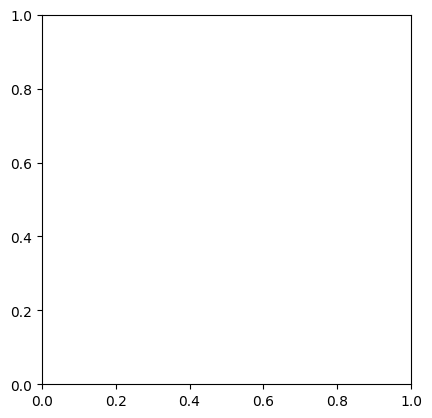

In [91]:
index = int(input("Please enter the index of the certain digit to test: "))

plot_digit([x[index]])

w1, w2 = train_ann([x[index]], [Y_expanded[index]], W1, W2, learning_rate=0.0008, num_iterations=1000)

a3 = forward_propagation(w1, w2, x[index])[0]

print(a3)

predicted_digit = (a3[0].index(max(a3[0])) + 1) % 10

print("Digit we predict is :", predicted_digit)